<a href="https://colab.research.google.com/github/joanizba/stonks/blob/main/Cohortes_proyecto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
cr = pd.read_csv("cash request.csv")
fee = pd.read_csv("fees.csv")
merged_df = cr.merge(
    fee,
    left_on="id",  # En cr la columna se llama "id"
    right_on="cash_request_id",  # En fee la clave es "cash_request_id"
    how="left",  # Mantener todas las filas de cr
    suffixes=("", "_fees")  # Agregar sufijo "_fees" a las columnas duplicadas
)
merged_df.drop(columns=["cash_request_id"], inplace=True)
merged_df.to_csv('merged_left.csv', index=False)
cr.loc[:, 'id_completo'] = cr['user_id'].combine_first(cr['deleted_account_id'])
cr['id_completo'] = cr['id_completo'].astype(int)

usuarios_activos = merged_df[merged_df['user_id'].notna()]
usuarios_eliminados = merged_df[merged_df['deleted_account_id'].notna()]

usuarios_activos.to_csv('users_active.csv', index=False)
usuarios_eliminados.to_csv('users_deleted.csv', index=False)
u_a = pd.read_csv("users_active.csv")
u_d = pd.read_csv("users_deleted.csv")
#print(df.info())
#object_columns = df.select_dtypes(include=['object']).columns
#eliminar columnas

# Mostrar las columnas de tipo object
#print(merge_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          32094 non-null  int64  
 1   amount                      32094 non-null  float64
 2   status                      32094 non-null  object 
 3   created_at                  32094 non-null  object 
 4   updated_at                  32094 non-null  object 
 5   user_id                     29522 non-null  float64
 6   moderated_at                21759 non-null  object 
 7   deleted_account_id          2573 non-null   float64
 8   reimbursement_date          32094 non-null  object 
 9   cash_request_received_date  24149 non-null  object 
 10  money_back_date             23917 non-null  object 
 11  transfer_type               32094 non-null  object 
 12  send_at                     22678 non-null  object 
 13  recovery_status             720

In [ ]:
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr['created_at'] = cr['created_at'].dt.tz_localize(None)
cr['Mes'] = cr['created_at'].dt.to_period('M')

cr['Cohorte'] = cr.groupby('id_completo')['created_at'].transform('min').dt.to_period('M')

In [ ]:
import pandas as pd
import numpy as np

quantiles =[cr['amount'].min() , 50 , 150 , cr['amount'].max()]
labels = ['Bronce', 'Plata', 'Oro']


cr['amount_cat'] = pd.cut(cr['amount'], bins=quantiles, labels=labels, include_lowest=True)
users_group = {
    'Bronce': cr.loc[cr['amount_cat'] == 'Bronce', 'id_completo'].tolist(),
    'Plata': cr.loc[cr['amount_cat'] == 'Plata', 'id_completo'].tolist(),
    'Oro': cr.loc[cr['amount_cat'] == 'Oro', 'id_completo'].tolist()
}
print(users_group)

# Mostrar los primeros registros para verificar
#print(df[['amount', 'amount_category','amount_label']])


{'Bronce': [2908, 163, 2460, 302, 21465, 23318, 115, 38075, 2575, 3131, 1628, 1003, 792, 1601, 30317, 1773, 1628, 2481, 486, 10560, 3558, 6812, 1861, 1047, 486, 1393, 3109, 5620, 486, 2481, 18155, 7318, 8638, 36166, 4685, 860, 5594, 597, 8564, 8157, 1895, 6792, 1264, 8040, 10203, 7780, 3377, 10516, 97141, 8857, 6461, 5496, 3849, 8456, 6345, 1022, 8674, 3377, 6511, 8720, 8638, 27816, 1310, 9953, 1310, 6929, 3377, 8873, 1310, 9308, 31320, 7903, 26854, 4508, 1159, 6162, 5284, 10208, 8986, 1776, 36013, 6931, 2274, 38553, 8831, 8787, 9442, 8412, 86577, 30482, 8707, 4916, 6879, 860, 47, 8908, 9843, 16874, 14912, 8541, 9973, 2102, 1310, 29684, 3780, 4868, 8700, 22261, 38153, 2128, 30872, 20598, 25850, 25169, 17519, 10086, 10414, 1672, 14249, 6179, 20583, 15000, 13655, 2142, 12150, 13049, 11247, 10123, 10370, 8809, 4626, 2838, 52, 2102, 21476, 3750, 12159, 22501, 11294, 22783, 10130, 31231, 2534, 21876, 26268, 23542, 3377, 2128, 15020, 36069, 33200, 9748, 6976, 34591, 14158, 29077, 18467, 3002

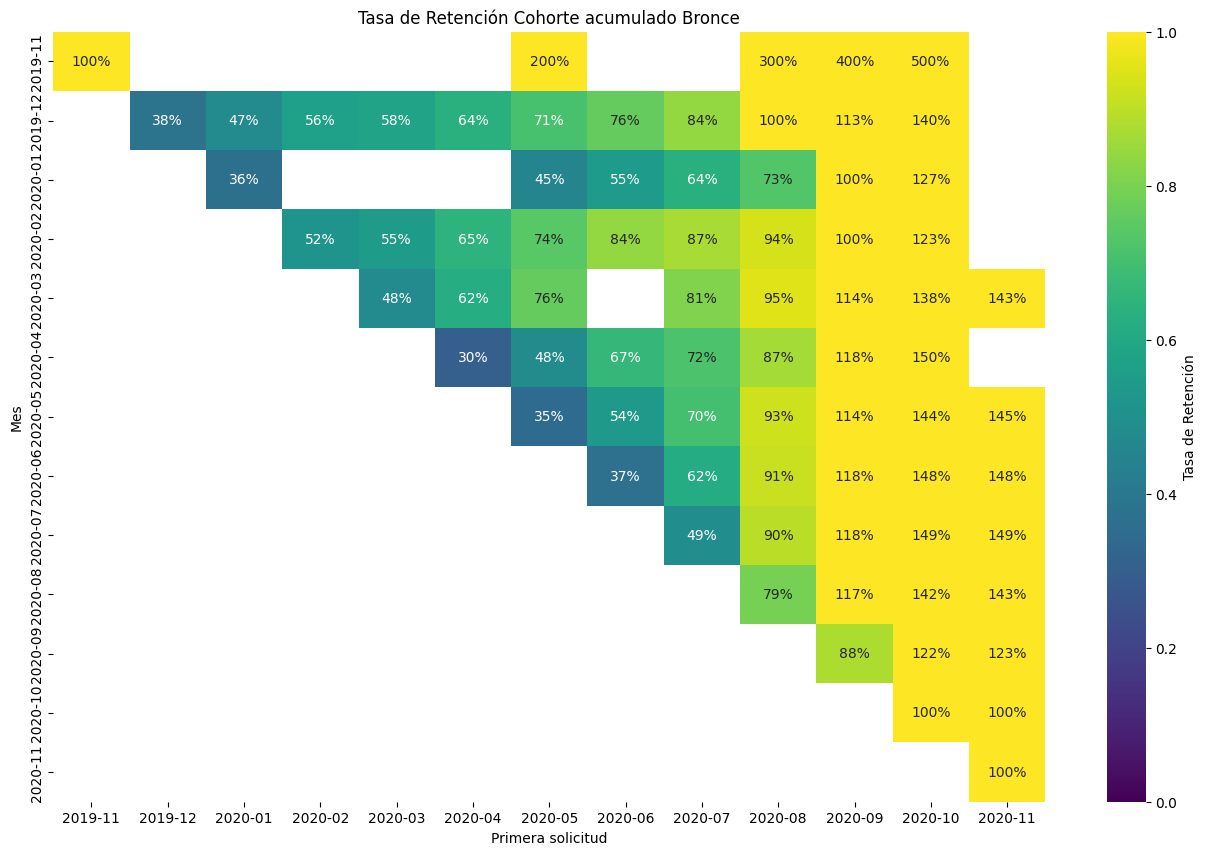

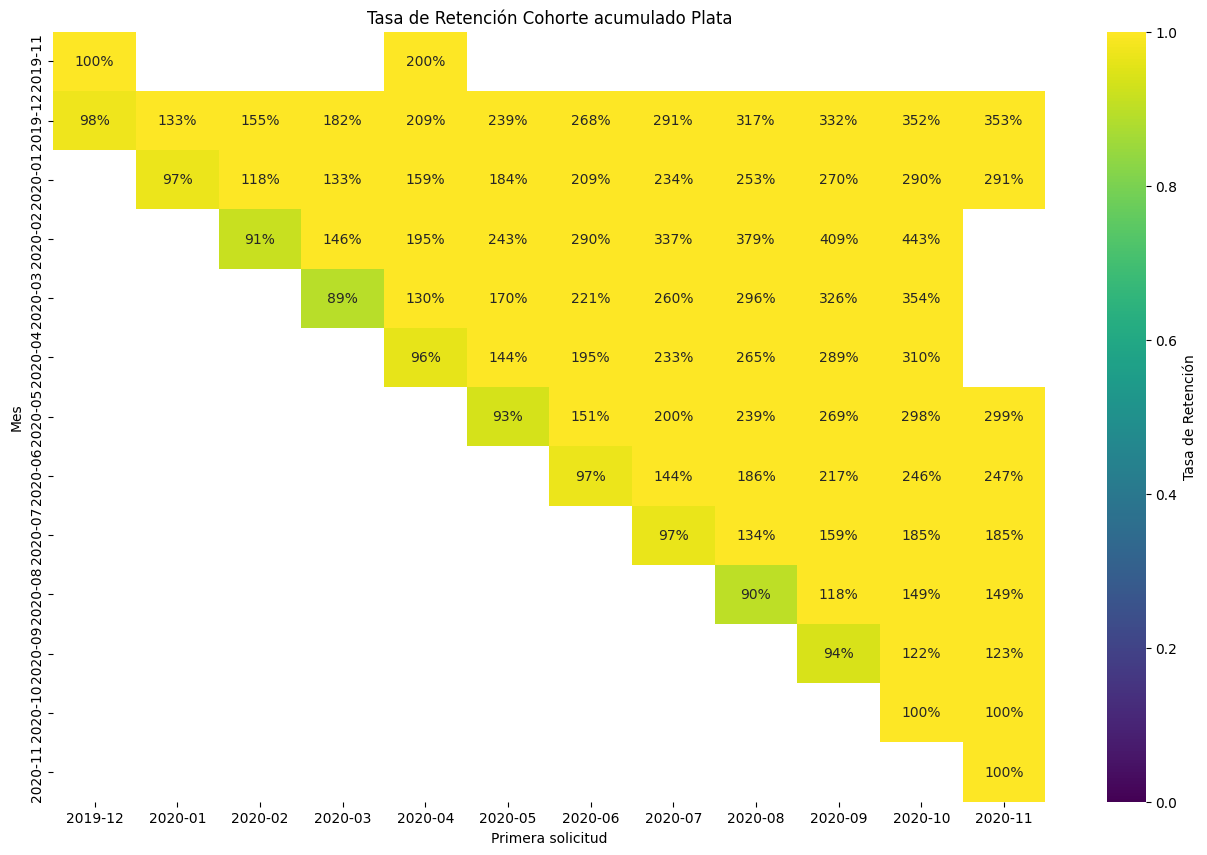

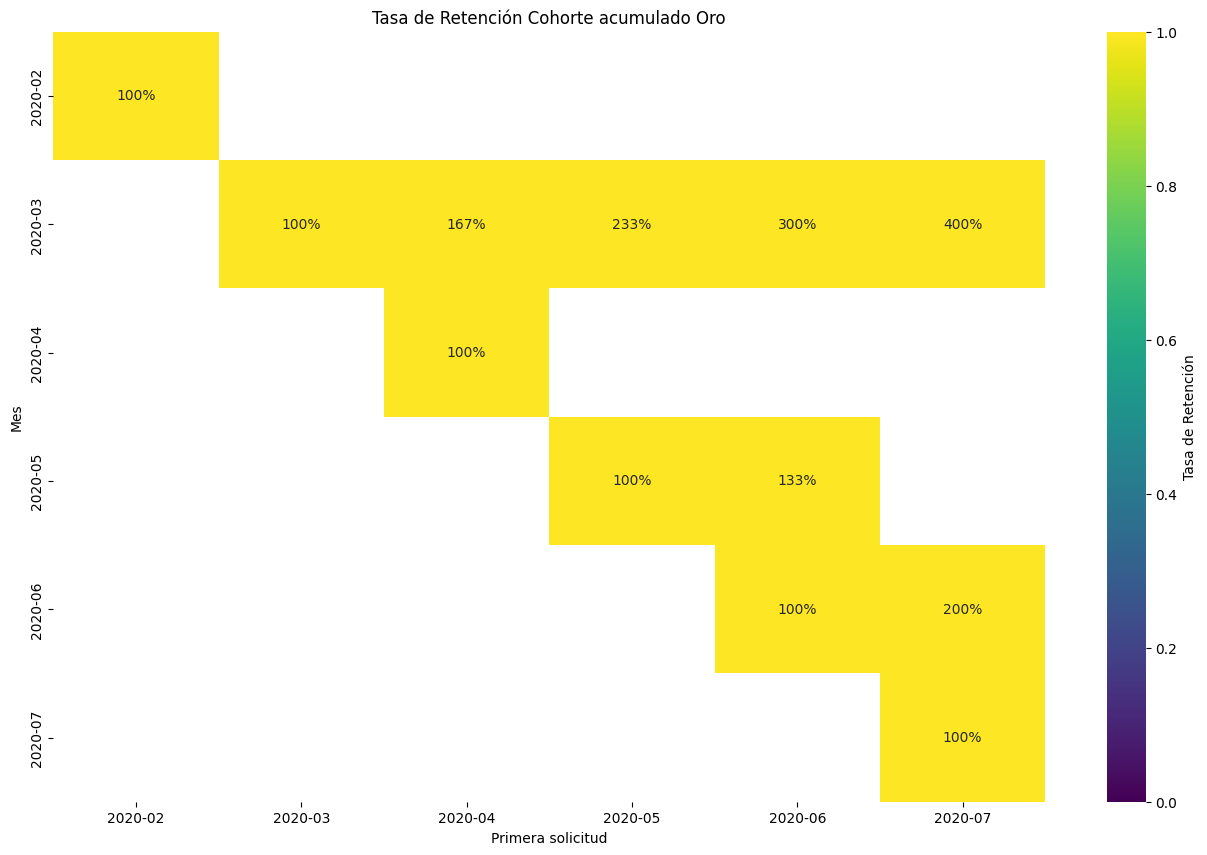

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for cat in labels:

    cohorte_cat = cr[cr['amount_cat'] == cat]
    retention_all_users = cohorte_cat.pivot_table(index='Cohorte',
                                                  columns='Mes',
                                                  values='id_completo',
                                                  aggfunc='nunique')
    retention_all_users = retention_all_users.cumsum(axis=1)
    retention_all_users = retention_all_users.div(cohorte_cat.groupby('Cohorte')['id_completo'].nunique(), axis=0)

    plt.figure(figsize=(16, 10))
    plt.title(f'Tasa de Retención Cohorte acumulado {cat}')

    sns.heatmap(data=retention_all_users, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='viridis', cbar_kws={'label': 'Tasa de Retención'})
    plt.xlabel('Primera solicitud')
    plt.ylabel('Mes')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for cat in labels:

    cohorte_cat = cr[cr['amonut_cat'] == cat]
    retention_all_users = cohorte_cat.pivot_table(index='Cohorte',
                                                  columns='Mes',
                                                  values='id_completo',
                                                  aggfunc='nunique')
    retention_all_users = retention_all_users.div(cohorte_cat.groupby('Cohorte')['id_completo'].nunique(), axis=0)

    plt.figure(figsize=(16, 10))
    plt.title(f'Tasa de Retención Cohorte {cat}')

    sns.heatmap(data=retention_all_users, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='viridis', cbar_kws={'label': 'Tasa de Retención'})
    plt.xlabel('Primera solicitud')
    plt.ylabel('Mes')
    plt.show()

KeyError: 'amonut_cat'

In [ ]:
u_a.drop(columns=["deleted_account_id"], inplace=True)

In [ ]:
u_d.drop(columns=["user_id"], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2573 entries, 0 to 2572
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          2573 non-null   int64   
 1   amount                      2573 non-null   float64 
 2   status                      2573 non-null   object  
 3   created_at                  2573 non-null   object  
 4   updated_at                  2573 non-null   object  
 5   user_id                     1 non-null      float64 
 6   moderated_at                2326 non-null   object  
 7   deleted_account_id          2573 non-null   float64 
 8   reimbursement_date          2573 non-null   object  
 9   cash_request_received_date  1162 non-null   object  
 10  money_back_date             1168 non-null   object  
 11  transfer_type               2573 non-null   object  
 12  send_at                     1325 non-null   object  
 13  recovery_status   

In [ ]:
u_a.info()

In [ ]:
u_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2573 entries, 0 to 2572
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          2573 non-null   int64   
 1   amount                      2573 non-null   float64 
 2   status                      2573 non-null   object  
 3   created_at                  2573 non-null   object  
 4   updated_at                  2573 non-null   object  
 5   moderated_at                2326 non-null   object  
 6   deleted_account_id          2573 non-null   float64 
 7   reimbursement_date          2573 non-null   object  
 8   cash_request_received_date  1162 non-null   object  
 9   money_back_date             1168 non-null   object  
 10  transfer_type               2573 non-null   object  
 11  send_at                     1325 non-null   object  
 12  recovery_status             466 non-null    object  
 13  reco_creation     

In [ ]:
u_a['created_at'] = pd.to_datetime(u_a['created_at'], errors="coerce")
u_a['created_at'] = u_a['created_at'].dt.tz_localize(None)
u_a['Mes'] = u_a['created_at'].dt.to_period('M')
u_a['Cohorte'] = u_a.groupby('user_id')['created_at'].transform('min').dt.to_period('M')

In [ ]:
u_d['created_at'] = pd.to_datetime(u_d['created_at'])
u_d['created_at'] = u_d['created_at'].dt.tz_localize(None)
u_d['Mes'] = u_d['created_at'].dt.to_period('M')
u_d['Cohorte'] = u_d.groupby('deleted_account_id')['created_at'].transform('min').dt.to_period('M')

In [ ]:
import pandas as pd
import numpy as np

quantiles =[u_a['amount'].min() , 50 , 150 , u_a['amount'].max()]
labels = ['Bronce', 'Plata', 'Oro']


u_a['amount_cat'] = pd.cut(u_a['amount'], bins=quantiles, labels=labels, include_lowest=True)
users_group = {
    'Bronce': u_a.loc[u_a['amount_cat'] == 'Bronce', 'user_id'].tolist(),
    'Plata': u_a.loc[u_a['amount_cat'] == 'Plata', 'user_id'].tolist(),
    'Oro': u_a.loc[u_a['amount_cat'] == 'Oro', 'user_id'].tolist()
}
print(users_group)

{'Bronce': [2908.0, 163.0, 2460.0, 21465.0, 23318.0, 115.0, 38075.0, 2575.0, 3131.0, 1628.0, 1003.0, 792.0, 1601.0, 1773.0, 1628.0, 2481.0, 10560.0, 3558.0, 6812.0, 1861.0, 1393.0, 3109.0, 5620.0, 2481.0, 18155.0, 7318.0, 8638.0, 36166.0, 4685.0, 860.0, 5594.0, 597.0, 8564.0, 8157.0, 1895.0, 6792.0, 8040.0, 10203.0, 7780.0, 3377.0, 10516.0, 10516.0, 97141.0, 8857.0, 6461.0, 5496.0, 3849.0, 8456.0, 6345.0, 1022.0, 8674.0, 3377.0, 6511.0, 8720.0, 8638.0, 27816.0, 9953.0, 6929.0, 3377.0, 8873.0, 9308.0, 31320.0, 7903.0, 26854.0, 4508.0, 1159.0, 6162.0, 5284.0, 10208.0, 8986.0, 1776.0, 36013.0, 6931.0, 2274.0, 38553.0, 8831.0, 8787.0, 9442.0, 8412.0, 86577.0, 30482.0, 8707.0, 4916.0, 6879.0, 860.0, 47.0, 47.0, 8908.0, 9843.0, 16874.0, 14912.0, 8541.0, 9973.0, 2102.0, 29684.0, 4868.0, 8700.0, 22261.0, 38153.0, 30872.0, 20598.0, 25850.0, 25169.0, 17519.0, 10086.0, 10414.0, 14249.0, 6179.0, 20583.0, 15000.0, 13655.0, 2142.0, 12150.0, 13049.0, 11247.0, 10123.0, 10370.0, 8809.0, 4626.0, 2838.0,

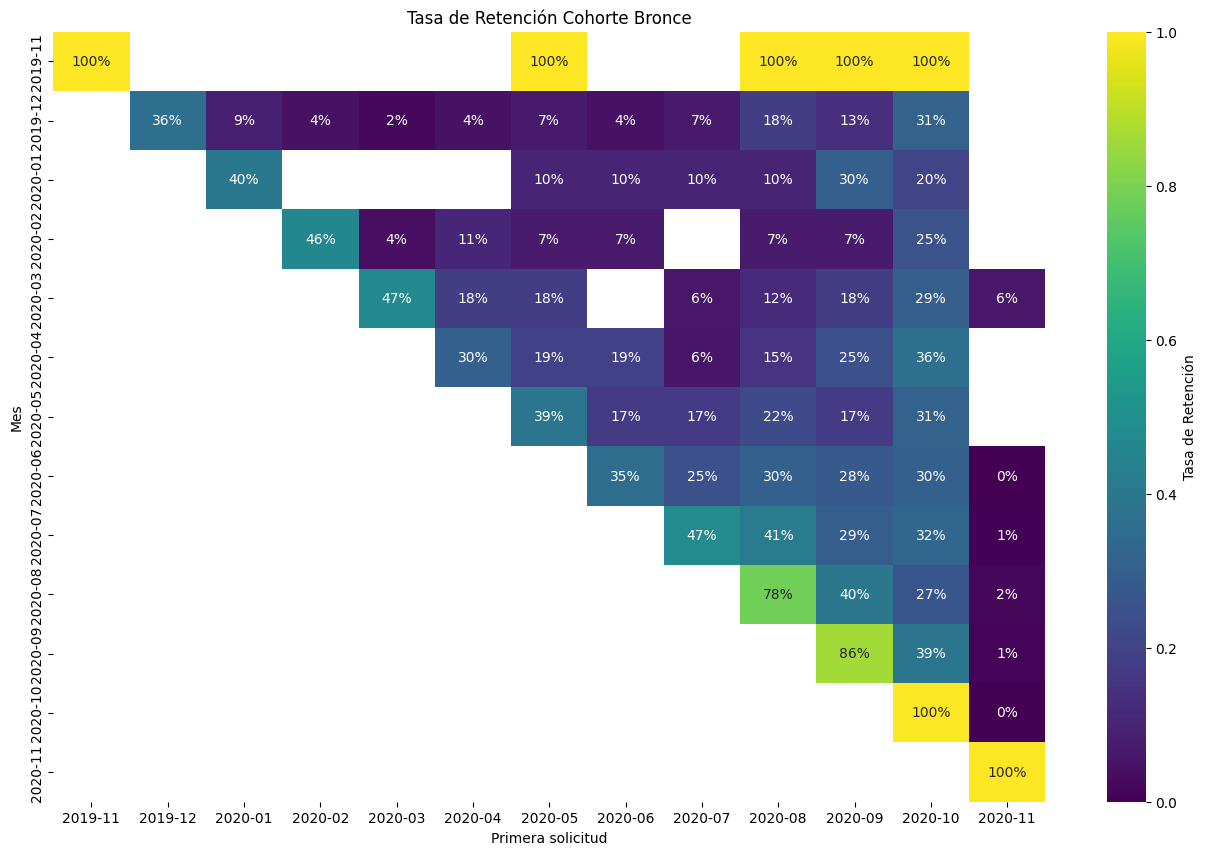

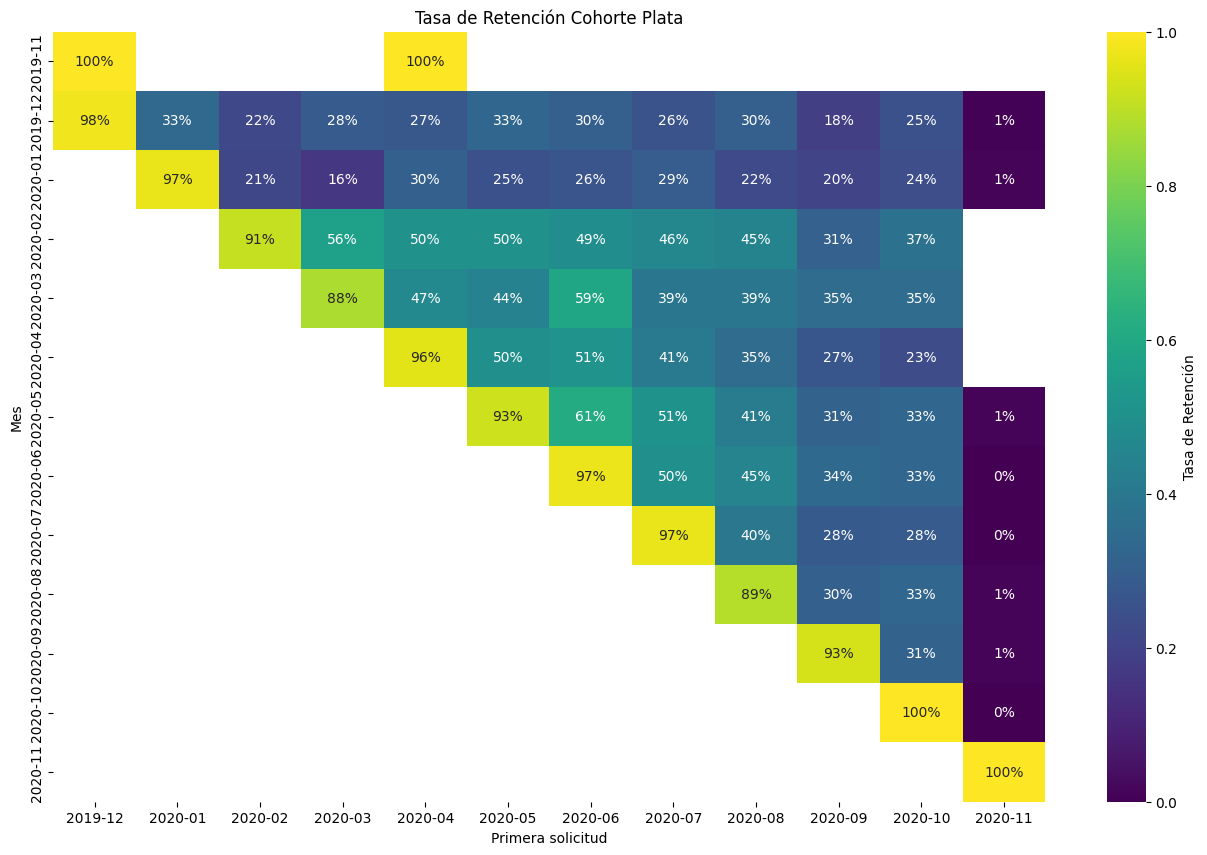

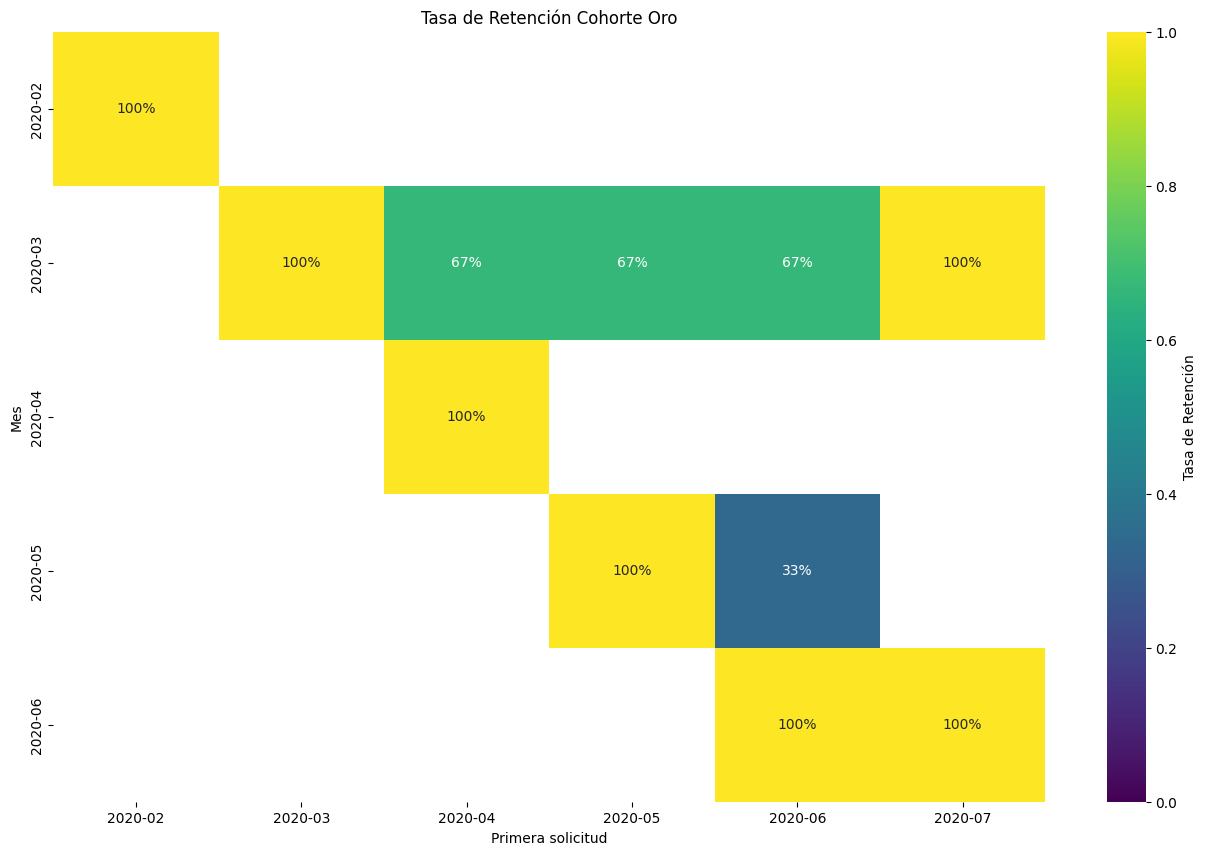

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for cat in labels:

    cohorte_cat = u_a[u_a['amount_cat'] == cat]
    retention_all_users = cohorte_cat.pivot_table(index='Cohorte',
                                                  columns='Mes',
                                                  values='user_id',
                                                  aggfunc='nunique')
    retention_all_users = retention_all_users.div(cohorte_cat.groupby('Cohorte')['user_id'].nunique(), axis=0)

    plt.figure(figsize=(16, 10))
    plt.title(f'Tasa de Retención Cohorte {cat}')

    sns.heatmap(data=retention_all_users, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='viridis', cbar_kws={'label': 'Tasa de Retención'})
    plt.xlabel('Primera solicitud')
    plt.ylabel('Mes')
    plt.show()

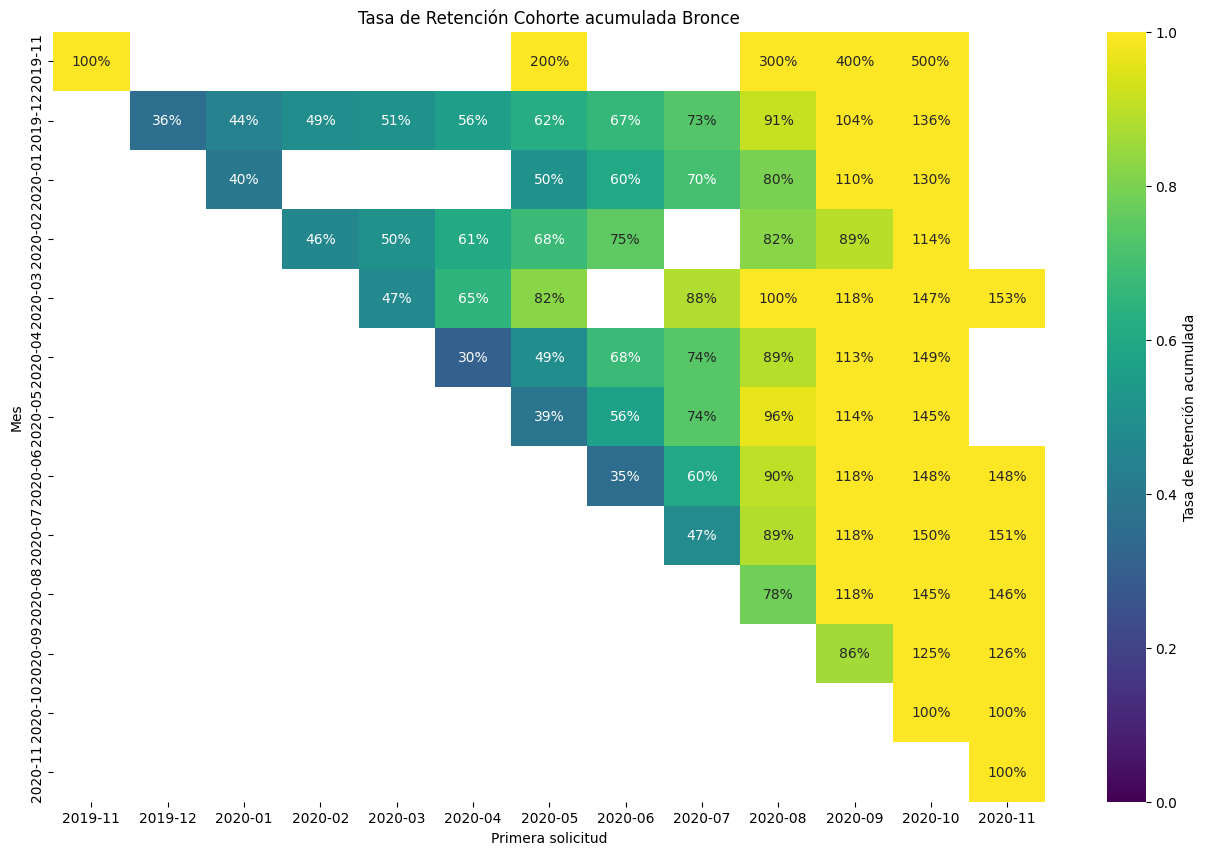

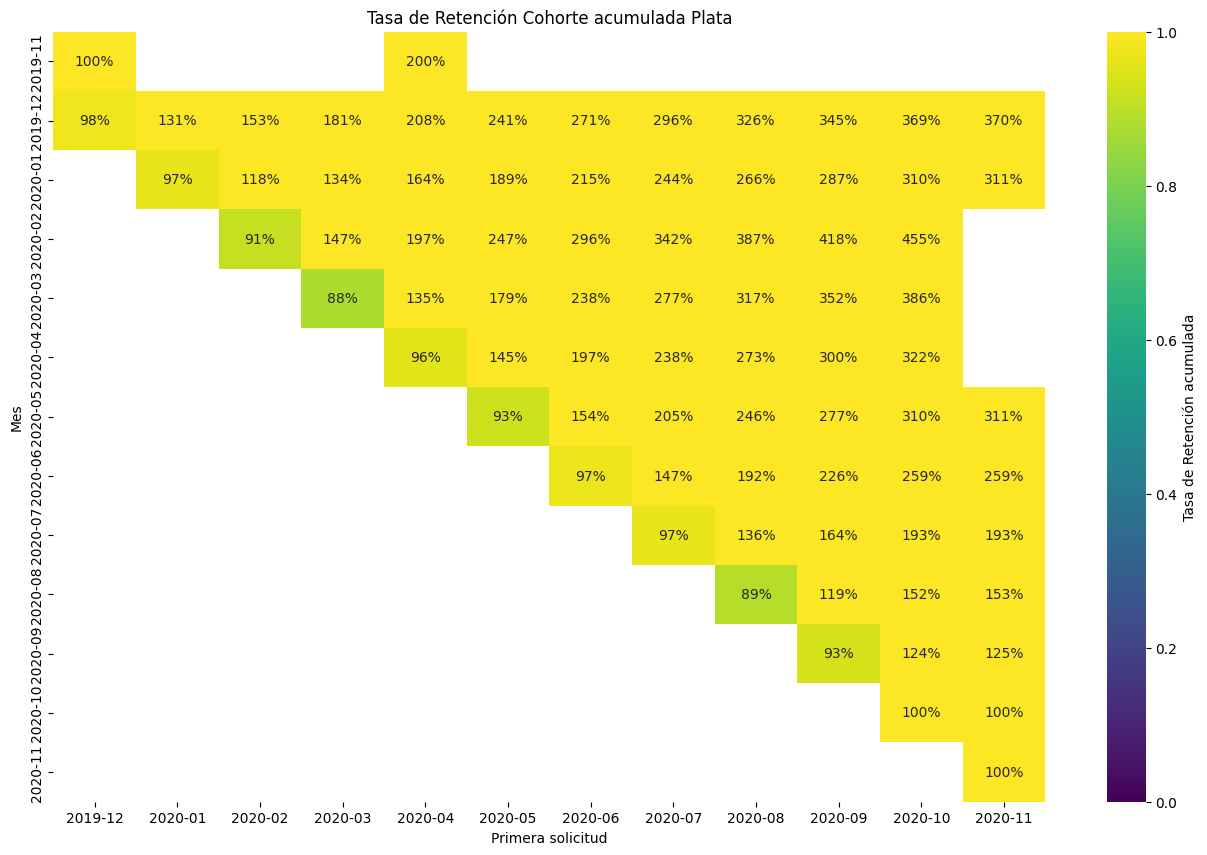

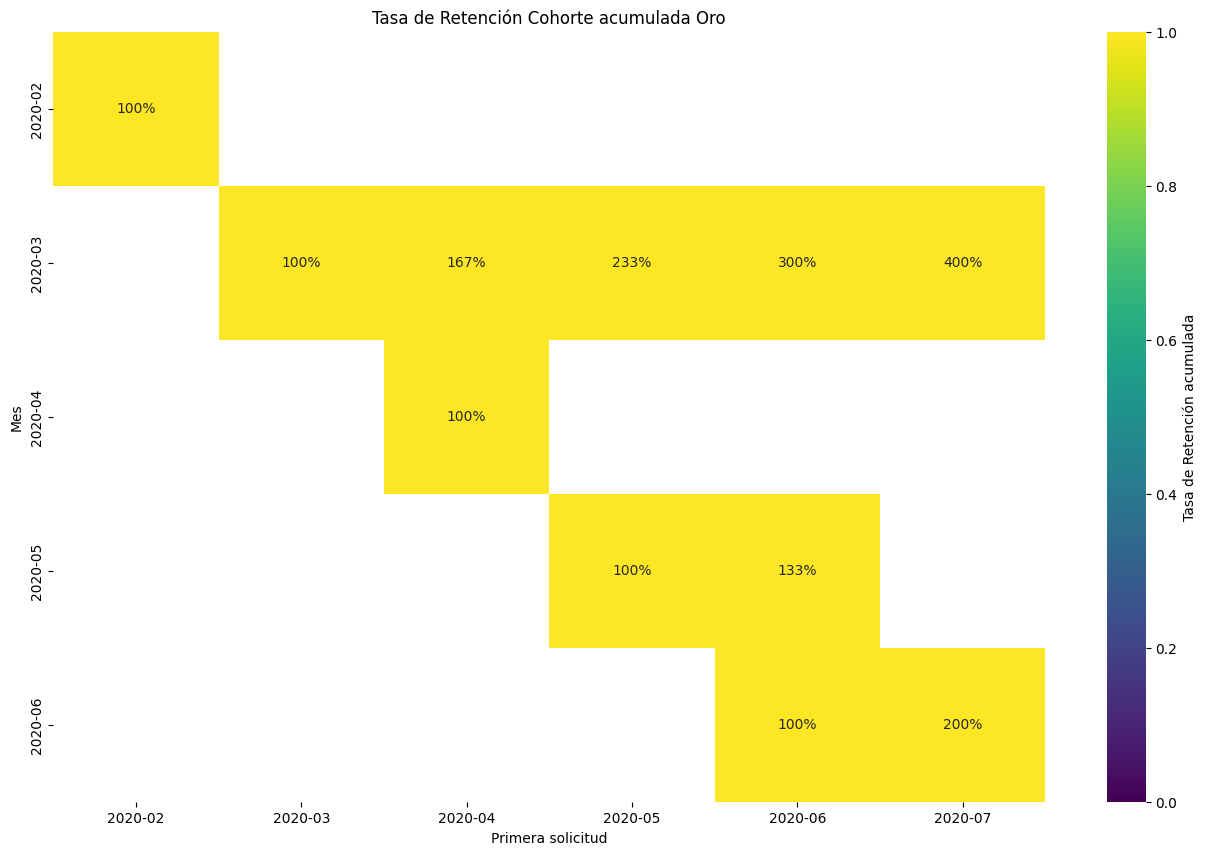

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for cat in labels:

    cohorte_cat = u_a[u_a['amount_cat'] == cat]
    retention_all_users = cohorte_cat.pivot_table(index='Cohorte',
                                                  columns='Mes',
                                                  values='user_id',
                                                  aggfunc='nunique')
    retention_all_users = retention_all_users.cumsum(axis=1)
    retention_all_users = retention_all_users.div(cohorte_cat.groupby('Cohorte')['user_id'].nunique(), axis=0)

    plt.figure(figsize=(16, 10))
    plt.title(f'Tasa de Retención Cohorte acumulada {cat}')

    sns.heatmap(data=retention_all_users, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='viridis', cbar_kws={'label': 'Tasa de Retención acumulada'})
    plt.xlabel('Primera solicitud')
    plt.ylabel('Mes')
    plt.show()

In [ ]:
import pandas as pd
import numpy as np

quantiles =[u_d['amount'].min() , 50 , 150 , u_d['amount'].max()]
labels = ['Bronce', 'Plata', 'Oro']


u_d['amount_cat'] = pd.cut(u_d['amount'], bins=quantiles, labels=labels, include_lowest=True)
users_group = {
    'Bronce': u_d.loc[u_d['amount_cat'] == 'Bronce', 'deleted_account_id'].tolist(),
    'Plata': u_d.loc[u_d['amount_cat'] == 'Plata', 'deleted_account_id'].tolist(),
    'Oro': u_d.loc[u_d['amount_cat'] == 'Oro', 'deleted_account_id'].tolist()
}
print(users_group)

{'Bronce': [302.0, 30317.0, 30317.0, 486.0, 1047.0, 486.0, 486.0, 1264.0, 1310.0, 1310.0, 1310.0, 1310.0, 3780.0, 2128.0, 1672.0, 3750.0, 2534.0, 2128.0, 5543.0, 2037.0, 8373.0, 2142.0, 8794.0, 15718.0, 1986.0, 1991.0, 2057.0, 9917.0, 1956.0, 2600.0, 2605.0, 3305.0, 3869.0, 3099.0, 14798.0, 15953.0, 3676.0, 4720.0, 3171.0, 3646.0, 4696.0, 3767.0, 5578.0, 3494.0, 3786.0, 3767.0, 13808.0, 3838.0, 4149.0, 3773.0, 3767.0, 3831.0, 3887.0, 3828.0, 3767.0, 3981.0, 3767.0, 3425.0, 4047.0, 4047.0, 4047.0, 4047.0, 4047.0, 5511.0, 4698.0, 4169.0, 4047.0, 25993.0, 3700.0, 4368.0, 3877.0, 7180.0, 3767.0, 4047.0, 3758.0, 25993.0, 9475.0, 7035.0, 3792.0, 4079.0, 17666.0, 3780.0, 3725.0, 3725.0, 3964.0, 3981.0, 3811.0, 3811.0, 3705.0, 3641.0, 3812.0, 3919.0, 3626.0, 4479.0, 3834.0, 4381.0, 3828.0, 3823.0, 4047.0, 3767.0, 4385.0, 7035.0, 4137.0, 4137.0, 4388.0, 4289.0, 3989.0, 4452.0, 4190.0, 3749.0, 3773.0, 4144.0, 8873.0, 10273.0, 4258.0, 5351.0, 3636.0, 17685.0, 17685.0, 17685.0, 5111.0, 3981.0, 523

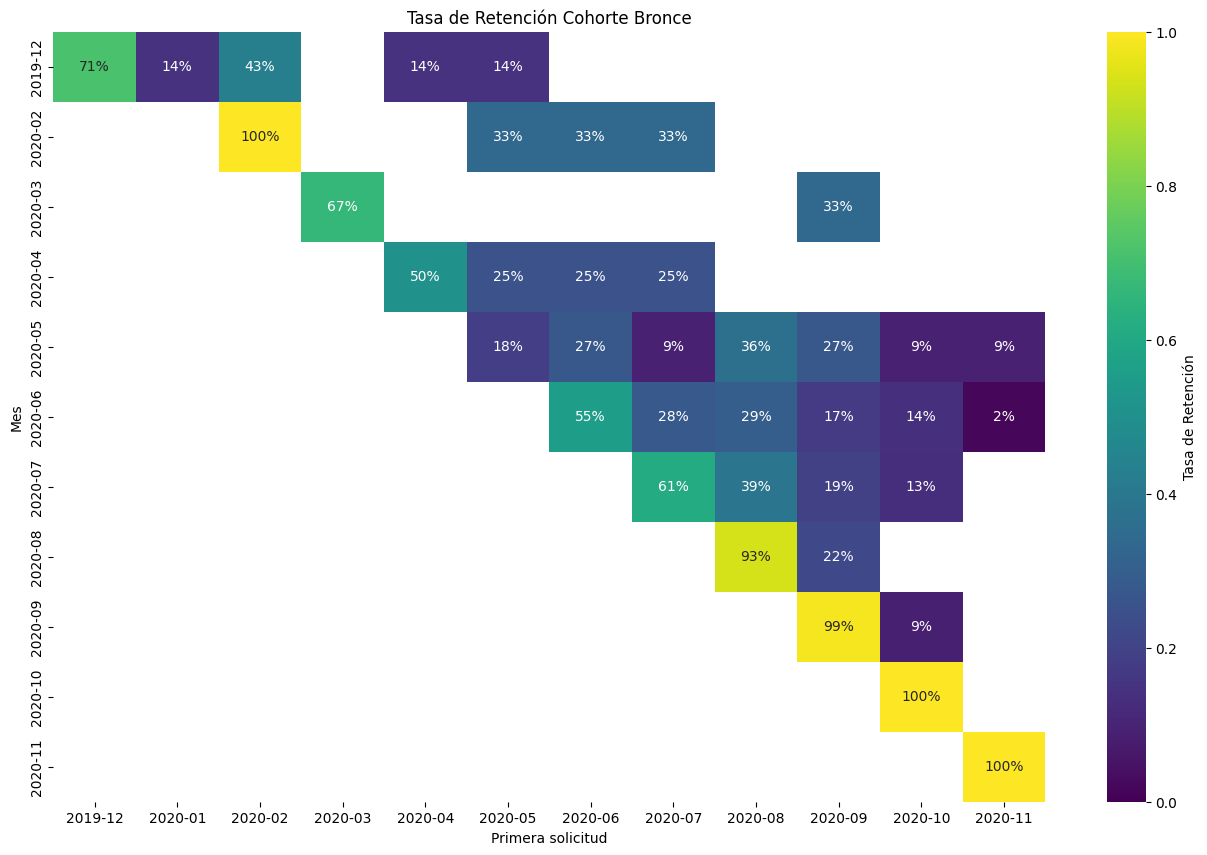

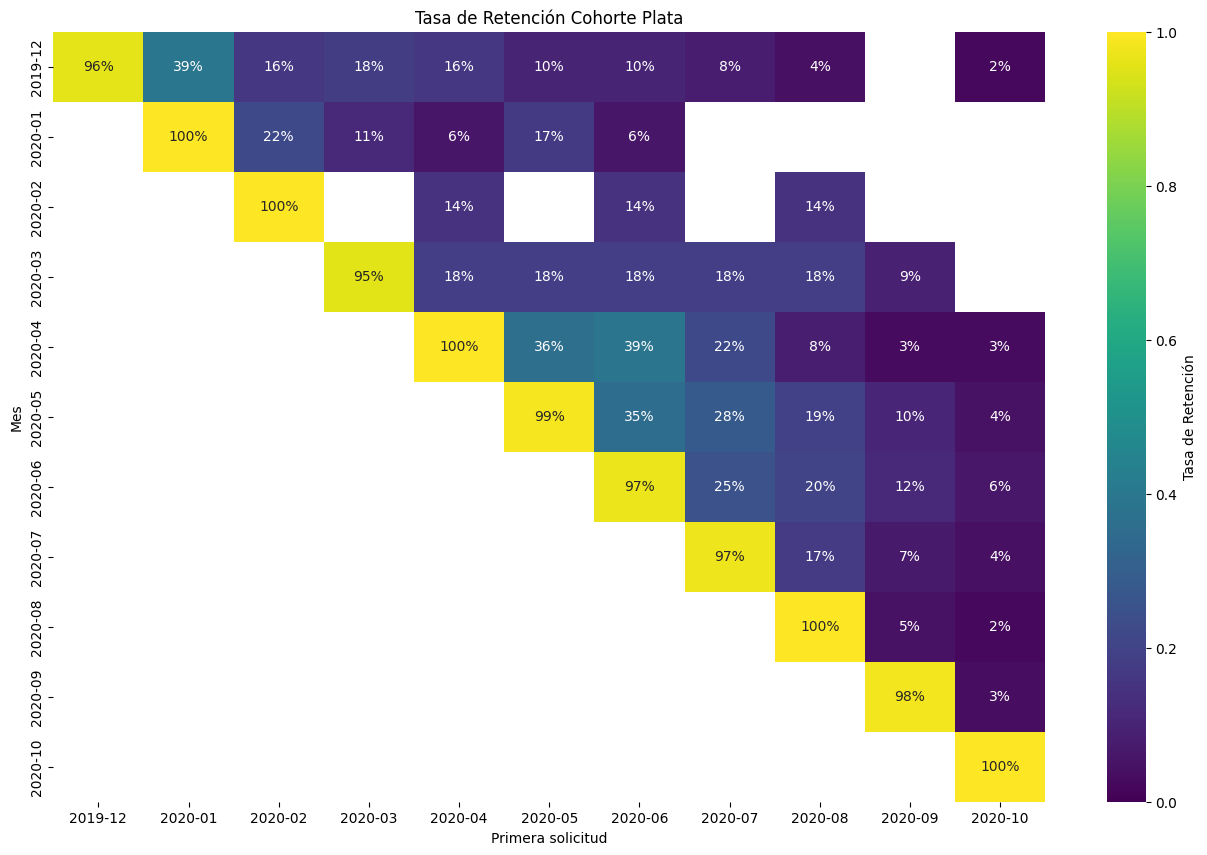

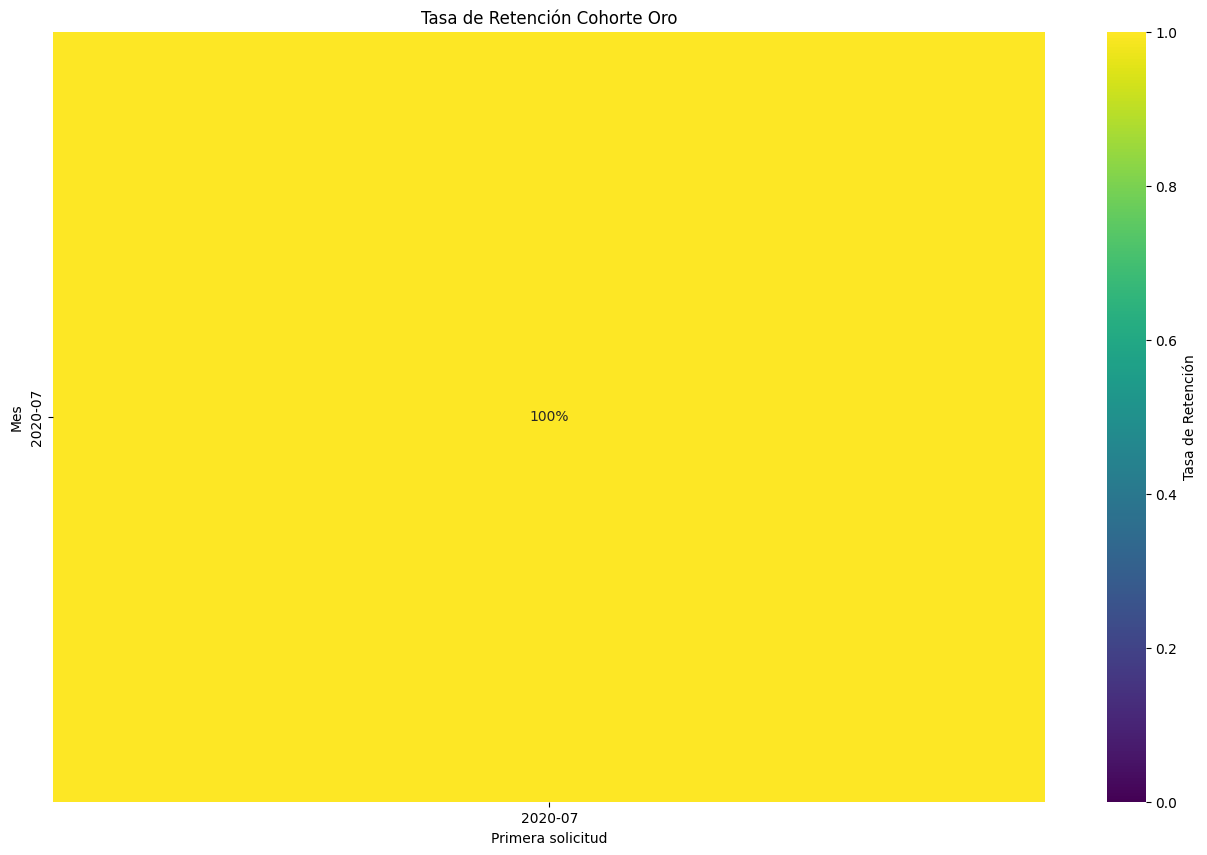

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for cat in labels:

    cohorte_cat = u_d[u_d['amount_cat'] == cat]
    retention_all_users = cohorte_cat.pivot_table(index='Cohorte',
                                                  columns='Mes',
                                                  values='deleted_account_id',
                                                  aggfunc='nunique')
    retention_all_users = retention_all_users.div(cohorte_cat.groupby('Cohorte')['deleted_account_id'].nunique(), axis=0)

    plt.figure(figsize=(16, 10))
    plt.title(f'Tasa de Retención Cohorte {cat}')

    sns.heatmap(data=retention_all_users, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='viridis', cbar_kws={'label': 'Tasa de Retención'})
    plt.xlabel('Primera solicitud')
    plt.ylabel('Mes')
    plt.show()

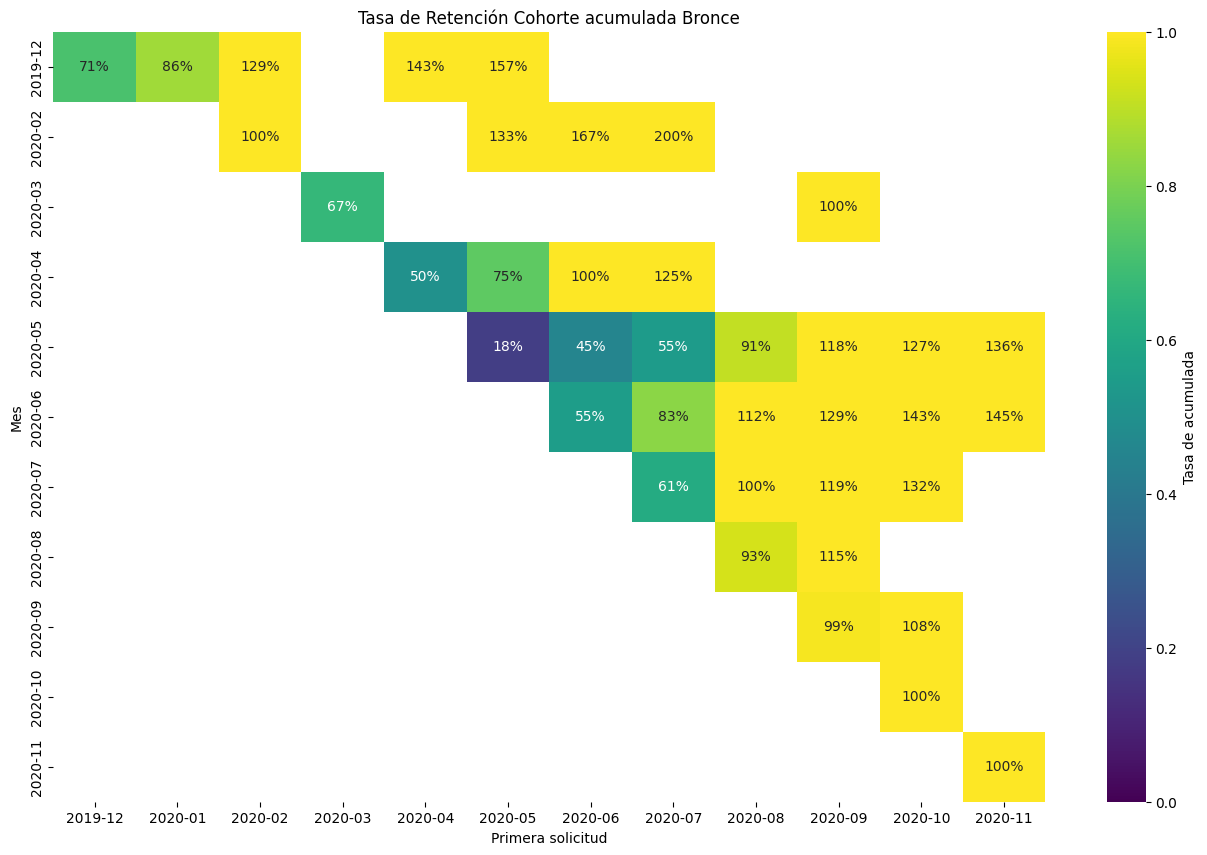

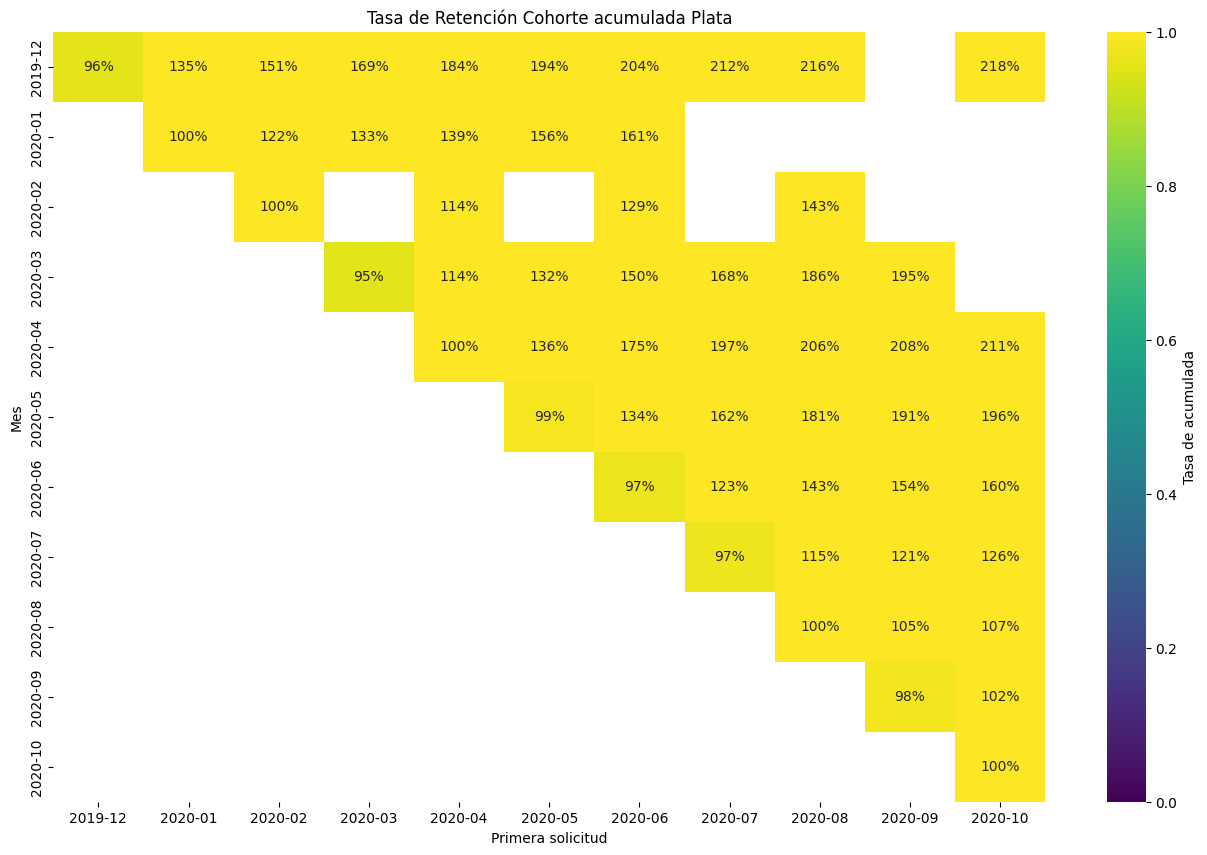

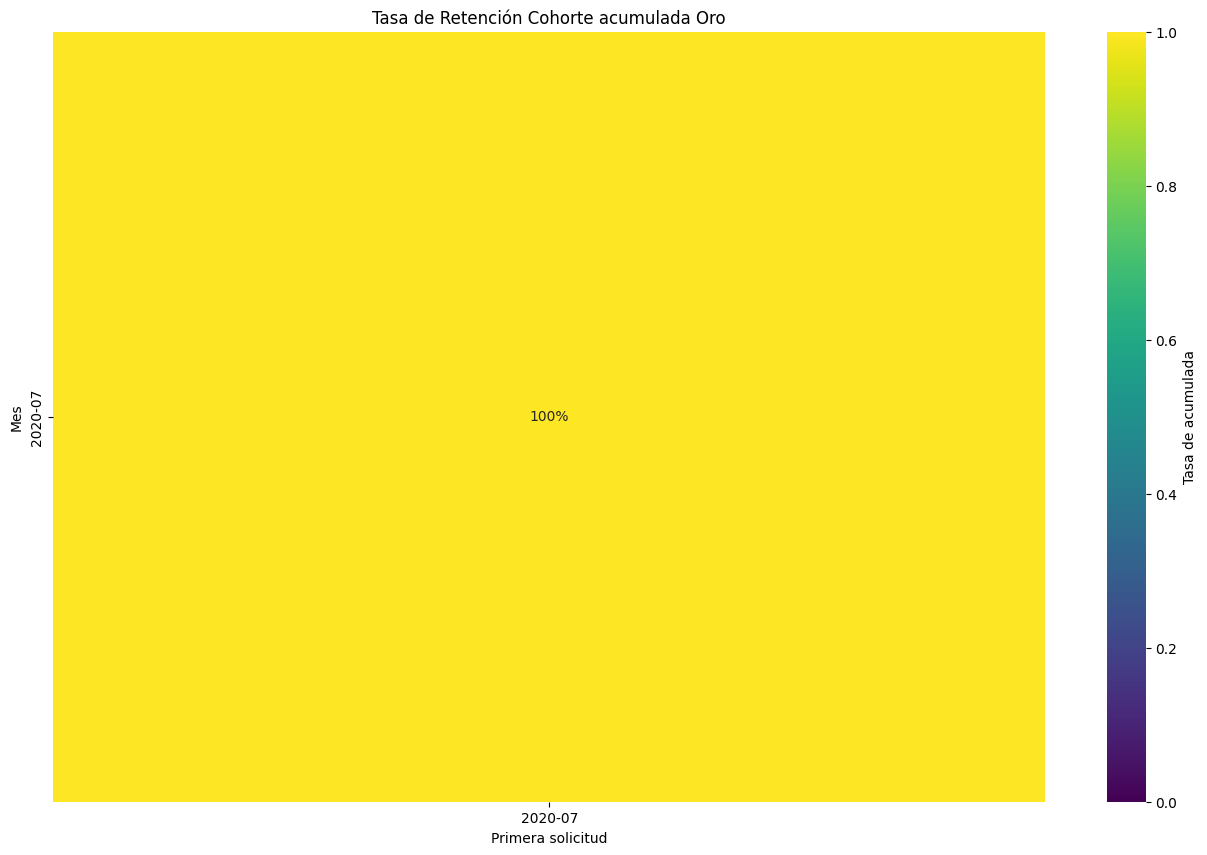

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for cat in labels:

    cohorte_cat = u_d[u_d['amount_cat'] == cat]
    retention_all_users = cohorte_cat.pivot_table(index='Cohorte',
                                                  columns='Mes',
                                                  values='deleted_account_id',
                                                  aggfunc='nunique')
    retention_all_users = retention_all_users.cumsum(axis=1)
    retention_all_users = retention_all_users.div(cohorte_cat.groupby('Cohorte')['deleted_account_id'].nunique(), axis=0)

    plt.figure(figsize=(16, 10))
    plt.title(f'Tasa de Retención Cohorte acumulada {cat}')

    sns.heatmap(data=retention_all_users, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,
                cmap='viridis', cbar_kws={'label': 'Tasa de acumulada'})
    plt.xlabel('Primera solicitud')
    plt.ylabel('Mes')
    plt.show()

In [ ]:
u_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29522 entries, 0 to 29521
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          29522 non-null  int64         
 1   amount                      29522 non-null  float64       
 2   status                      29522 non-null  object        
 3   created_at                  29522 non-null  datetime64[ns]
 4   updated_at                  29522 non-null  object        
 5   user_id                     29522 non-null  float64       
 6   moderated_at                19434 non-null  object        
 7   deleted_account_id          1 non-null      float64       
 8   reimbursement_date          29522 non-null  object        
 9   cash_request_received_date  22988 non-null  object        
 10  money_back_date             22750 non-null  object        
 11  transfer_type               29522 non-null  object    

## **ING CAT**

In [ ]:
print(u_a[["user_id", "created_at"]].head())

   user_id                 created_at
0    804.0 2019-12-10 19:05:21.596873
1    231.0 2019-12-10 19:50:12.347780
2    191.0 2019-12-10 19:13:35.825460
3    761.0 2019-12-10 19:16:10.880172
4   7686.0 2020-05-06 09:59:38.877376


In [ ]:
print(u_d[["deleted_account_id", "created_at"]].head())

   deleted_account_id                 created_at
0               309.0 2020-02-10 01:11:53.808270
1              2499.0 2020-06-28 12:06:33.712840
2               304.0 2020-01-29 13:53:03.343598
3               304.0 2020-02-05 17:37:56.852948
4                91.0 2019-12-11 07:30:42.567035


In [ ]:
u_a['total_sol'] = u_a['user_id'].value_counts().reset_index()

       user_id  total_sol
0      16391.0         37
1      15593.0         29
2       3045.0         28
3      23823.0         25
4      17144.0         25
...        ...        ...
10793  43359.0          1
10794  97197.0          1
10795  46254.0          1
10796  37466.0          1
10797    804.0          1

[10798 rows x 2 columns]


In [ ]:
u_d['total_sol'] = u_d['deleted_account_id'].value_counts().reset_index()

      deleted_account_id  total_sol
0                 7731.0         24
1                 4558.0         21
2                20447.0         20
3                 6334.0         19
4                21706.0         18
...                  ...        ...
1136              7602.0          1
1137              3031.0          1
1138              2821.0          1
1139              5925.0          1
1140              7508.0          1

[1141 rows x 2 columns]


In [ ]:
u_a['Operaciones_canceladas_rechazadas'] = u_a[u_a['status'].isin(["cancelled","rejected"])]["user_id"].value_counts().reset_index()

      user_id  Operaciones_canceladas_rechazadas
0      3377.0                                 18
1     15219.0                                 16
2      2142.0                                 15
3     13851.0                                 15
4     17329.0                                 15
...       ...                                ...
2605  16730.0                                  1
2606  47900.0                                  1
2607  34588.0                                  1
2608  33864.0                                  1
2609  92198.0                                  1

[2610 rows x 2 columns]


In [ ]:
u_d['Operaciones_canceladas_rechazadas'] = u_d[u_d['status'].isin(["cancelled","rejected"])]["deleted_account_id"].value_counts().reset_index()

     deleted_account_id  Operaciones_canceladas_rechazadas
0                6334.0                                 17
1                3767.0                                 15
2                4047.0                                 14
3               11444.0                                 14
4                4203.0                                  9
..                  ...                                ...
825              5490.0                                  1
826              1833.0                                  1
827              4407.0                                  1
828              4579.0                                  1
829             24903.0                                  1

[830 rows x 2 columns]


In [ ]:
u_a["tasa_rechazo"] = u_a["Operaciones_canceladas_rechazadas"] / u_a["total_sol"]
u_a["tasa_rechazo"] = u_a["tasa_rechazo"].replace([np.inf, -np.inf, np.nan], 0)

       user_id  tasa_rechazo
0        804.0      1.000000
1        231.0      0.200000
2        191.0      0.500000
3        761.0      1.000000
4       7686.0      1.000000
...        ...           ...
29517  82122.0      0.000000
29518  64517.0      0.000000
29519  64517.0      0.000000
29520  44867.0      0.333333
29521  44867.0      0.333333

[29522 rows x 2 columns]


In [ ]:
u_d["tasa_rechazo"] = u_d["Operaciones_canceladas_rechazadas"] / u_a["total_sol"]
u_d["tasa_rechazo"] = u_d["tasa_rechazo"].replace([np.inf, -np.inf, np.nan], 0)

      deleted_account_id  tasa_rechazo
0                  309.0           2.0
1                 2499.0           0.0
2                  304.0           1.0
3                  304.0           2.0
4                   91.0           1.0
...                  ...           ...
2568             29803.0           0.0
2569             29803.0           0.0
2570             29803.0           0.0
2571             30367.0           0.0
2572             30367.0           0.0

[2573 rows x 2 columns]


In [ ]:
u_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29522 entries, 0 to 29521
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 29522 non-null  int64         
 1   amount                             29522 non-null  float64       
 2   status                             29522 non-null  object        
 3   created_at                         29522 non-null  datetime64[ns]
 4   updated_at                         29522 non-null  object        
 5   user_id                            29522 non-null  float64       
 6   moderated_at                       19434 non-null  object        
 7   deleted_account_id                 1 non-null      float64       
 8   reimbursement_date                 29522 non-null  object        
 9   cash_request_received_date         22988 non-null  object        
 10  money_back_date                   

In [ ]:
category_mapping = {'Bronce': 1, 'Plata': 2, 'Oro': 3}  # Ajusta según tu caso
u_a["amount_cat_n"] = u_a["amount_cat"].map(category_mapping)
u_a["amount_cat_n"] = u_a["amount_cat_n"].astype(int)
print(u_a["amount_cat_n"])

0        2
1        2
2        2
3        2
4        2
        ..
29517    2
29518    2
29519    2
29520    2
29521    2
Name: amount_cat_n, Length: 29522, dtype: int64


In [ ]:
#eliminar columnas
u_a_2 = u_a.copy()
u_a_2.drop(columns=["updated_at","moderated_at","reimbursement_date","cash_request_received_date","money_back_date","send_at","reco_creation","reco_last_update","reason","created_at_fees","updated_at_fees","paid_at","from_date","to_date","charge_moment","category"], inplace=True, axis=0)
u_a_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29522 entries, 0 to 29521
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 29522 non-null  int64         
 1   amount                             29522 non-null  float64       
 2   status                             29522 non-null  object        
 3   created_at                         29522 non-null  datetime64[ns]
 4   user_id                            29522 non-null  float64       
 5   deleted_account_id                 1 non-null      float64       
 6   transfer_type                      29522 non-null  object        
 7   recovery_status                    6735 non-null   object        
 8   id_fees                            20151 non-null  float64       
 9   type                               20151 non-null  object        
 10  status_fees                       

In [ ]:
u_a_2.drop(columns=["recovery_status"], inplace=True, axis=0)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Codificar la columna status a números
encoder = LabelEncoder()
u_a_2["stauts_n"] = encoder.fit_transform(u_a_2['status'])
u_a_2["transfer_type_n"] = encoder.fit_transform(u_a_2['transfer_type'])
u_a_2["status_fees_n"] = encoder.fit_transform(u_a_2['status_fees'])
u_a_2["Mes"] = encoder.fit_transform(u_a_2['Mes'])
u_a_2["Cohorte"] = encoder.fit_transform(u_a_2['Cohorte'])

In [ ]:
u_a_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29522 entries, 0 to 29521
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 29522 non-null  int64         
 1   amount                             29522 non-null  float64       
 2   status                             29522 non-null  object        
 3   created_at                         29522 non-null  datetime64[ns]
 4   user_id                            29522 non-null  float64       
 5   deleted_account_id                 1 non-null      float64       
 6   transfer_type                      29522 non-null  object        
 7   id_fees                            20151 non-null  float64       
 8   type                               20151 non-null  object        
 9   status_fees                        20151 non-null  object        
 10  total_amount                      

<ipython-input-42-dcf129503d04>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  u_a_2['total_amount'].fillna(0, inplace=True)  # o usa otro valor apropiado


id                                   0.882758
amount                              -0.291336
user_id                              0.643388
deleted_account_id                        NaN
id_fees                              1.000000
total_amount                              NaN
Mes                                  0.826493
Cohorte                              0.583062
total_sol                           -0.408958
Operaciones_canceladas_rechazadas   -0.074835
tasa_rechazo                        -0.135821
amount_cat_n                        -0.254015
stauts_n                             0.018534
transfer_type_n                     -0.542388
status_fees_n                       -0.026474
Name: id_fees, dtype: float64


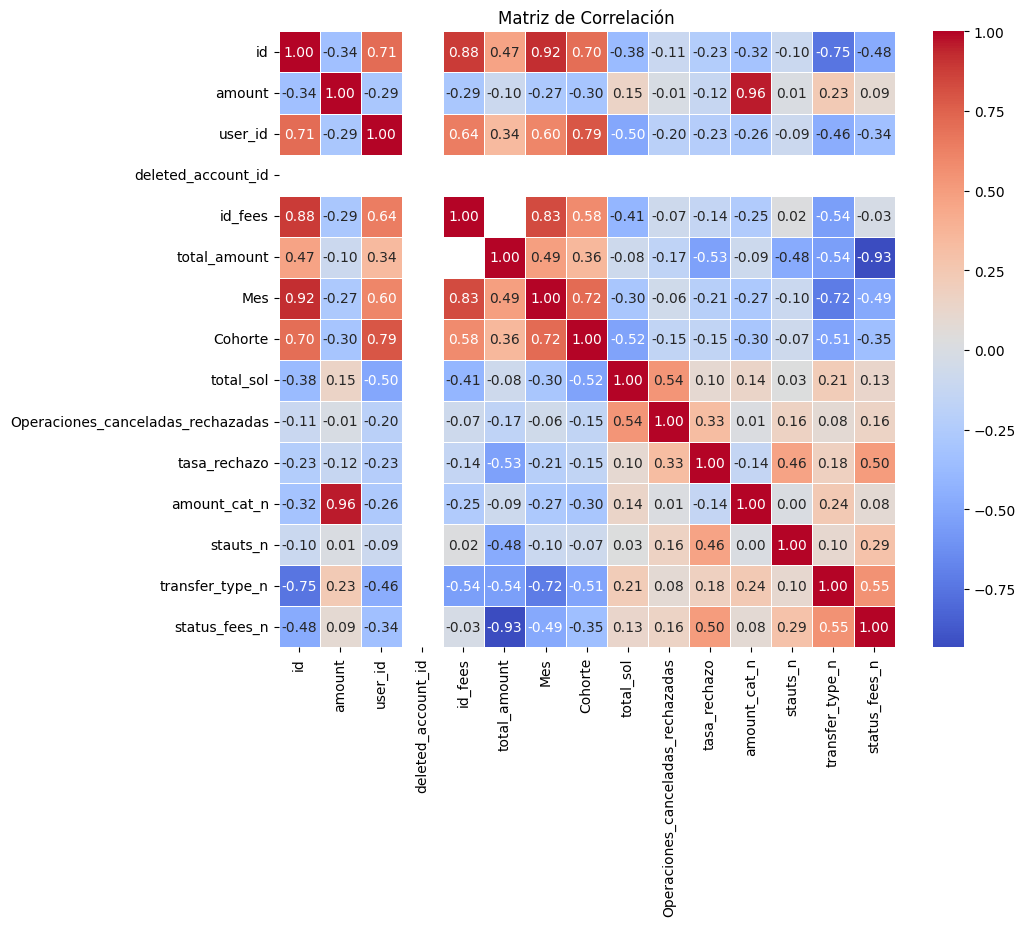

In [ ]:
#matriz correlación
#quitar tipo object
u_a_2.drop(columns=["status","transfer_type","type","status_fees","created_at","amount_cat"], inplace=True, axis=0)
#eliminar NaN de total_amount
u_a_2['total_amount'].fillna(0, inplace=True)  # o usa otro valor apropiado
correlation_matrix = u_a_2.corr()
print(correlation_matrix["id_fees"])
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

# **Clasificación**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Cargar los datos (Reemplaza con la carga real de tu DataFrame)
# Seleccionar columnas numéricas relevantes para K-Means
cols_kmeans = ['Mes','user_id']
X = u_a_2[cols_kmeans]

# Manejo de valores nulos (reemplazar por la media)
#X.fillna(X.mean())

# Normalizar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means con el número óptimo de clusters (ejemplo con k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
u_a_2["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

# graficar resultados del número optimo de clusters
import matplotlib.pyplot as plt
plt.scatter(X_scaled[:, 1], X_scaled[:, 0], c=u_a_2['cluster_kmeans'], cmap='viridis')
plt.xlabel('')
plt.ylabel('')

In [ ]:
u_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29522 entries, 0 to 29521
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 29522 non-null  int64         
 1   amount                             29522 non-null  float64       
 2   status                             29522 non-null  object        
 3   created_at                         29522 non-null  datetime64[ns]
 4   updated_at                         29522 non-null  object        
 5   user_id                            29522 non-null  float64       
 6   moderated_at                       19434 non-null  object        
 7   deleted_account_id                 1 non-null      float64       
 8   reimbursement_date                 29522 non-null  object        
 9   cash_request_received_date         22988 non-null  object        
 10  money_back_date                   

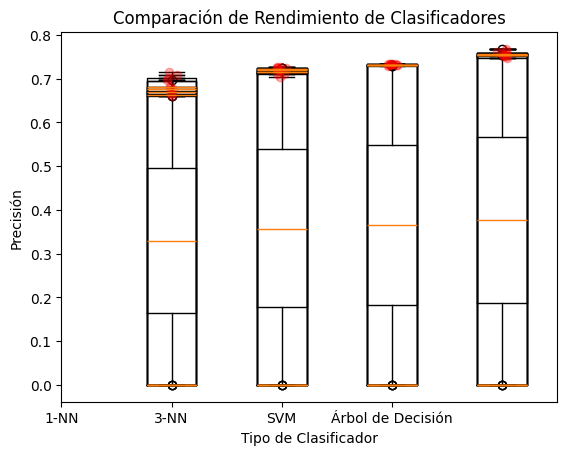

In [ ]:
from sklearn import model_selection
from sklearn import neighbors
from sklearn import tree
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

u_a["Mes"] = encoder.fit_transform(u_a['Mes'])
u_a["Cohorte"] = encoder.fit_transform(u_a['Cohorte'])

# Seleccionar las dos características más relevantes para clasificación
X = u_a[['Mes','total_sol','tasa_rechazo']].values  # Variables numéricas

y = u_a['amount_cat']


PRC = 0.1

acc_r = np.zeros((10, 4))

for i in range(10):

  X_train, X_test, y_train, y_test =model_selection.train_test_split(X, y, test_size=PRC, stratify=y)


  nn1 = neighbors.KNeighborsClassifier(n_neighbors=1)
  nn3 = neighbors.KNeighborsClassifier(n_neighbors=3)
  svc = svm.SVC()
  dt = tree.DecisionTreeClassifier()


  nn1.fit(X_train, y_train)
  nn3.fit(X_train, y_train)
  svc.fit(X_train, y_train)
  dt.fit(X_train, y_train)


  yhat_nn1 = nn1.predict(X_test)
  yhat_nn3 = nn3.predict(X_test)
  yhat_svc = svc.predict(X_test)
  yhat_dt = dt.predict(X_test)

  # Calcular y almacenar la precisión para cada clasificador
  acc_r[i][0] = metrics.accuracy_score(yhat_nn1, y_test)
  acc_r[i][1] = metrics.accuracy_score(yhat_nn3, y_test)
  acc_r[i][2] = metrics.accuracy_score(yhat_svc, y_test)
  acc_r[i][3] = metrics.accuracy_score(yhat_dt, y_test)

  plt.boxplot(acc_r);

for i in range(4):
  xderiv = (i+1)*np.ones(acc_r[:, i].shape) + (np.random.rand(10,)-0.5) * 0.1
  plt.plot(xderiv, acc_r[:, i], 'ro', alpha=0.3)

# Personalizar el gráfico con etiquetas apropiadas
ax = plt.gca()
plt.xticks(ticks=[0, 1, 2, 3], labels=["1-NN", "3-NN", "SVM", "Árbol de Decisión"])
plt.xlabel('Tipo de Clasificador')
plt.ylabel('Precisión')
plt.title('Comparación de Rendimiento de Clasificadores')
# Mostrar el gráfico
plt.show()


In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Asumiendo que el DataFrame u_a ya está cargado y con las categorías correctas
X = u_a[['amount', 'total_sol', 'total_amount', 'Operaciones_canceladas_rechazadas', 'tasa_rechazo']]
y = u_a['amount_cat']

# Manejar valores nulos llenando con la media de cada columna
X.fillna(X.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Evaluar el modelo
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# Calcular AUC para cada clase
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_prob = knn.predict_proba(X_test)

for i, clase in enumerate(knn.classes_):
    auc = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i ])
    print(f"AUC para la clase {clase}: {auc}")

# Visualización de precisión para distintos valores de k
accuracies = []
k_values = range(1, 21)
for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train, y_train)
    acc = knn_temp.score(X_test, y_test)
    accuracies.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Precisión en Prueba')
plt.title('Precisión del KNN para diferentes valores de k')
plt.show()



Reporte de Clasificación:
              precision    recall  f1-score   support

      Bronce       1.00      1.00      1.00       413
       Plata       1.00      1.00      1.00       466

    accuracy                           1.00       879
   macro avg       1.00      1.00      1.00       879
weighted avg       1.00      1.00      1.00       879

Matriz de Confusión:
[[413   0]
 [  2 464]]
AUC para la clase Bronce: 0.0


<ipython-input-94-52b054ae77f9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


IndexError: index 1 is out of bounds for axis 1 with size 1

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
# Codificar la columna 'Mes' a valores numéricos
encoder = LabelEncoder()
u_a["Cohorte"] = encoder.fit_transform(u_a['Cohorte'])
u_a = u_a.dropna(subset="Operaciones_canceladas_rechazadas")
# Seleccionar características y variable objetivo
X0_svm = u_a[['Cohorte', 'total_sol', 'tasa_rechazo','Operaciones_canceladas_rechazadas']]
y0_svm = u_a['amount_cat']

# Escalar características
scaler = StandardScaler()
X0_svm = scaler.fit_transform(X0_svm)
# Dividir en conjunto de entrenamiento y prueba
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X0_svm, y0_svm, test_size=0.3, random_state=42)

# Entrenar el clasificador SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_svm, y_train_svm)

# Realizar predicciones
y_pred_svm = svm_model.predict(X_test_svm)
ret = classification_report(y_test_svm, y_pred_svm)
con_max = confusion_matrix(y_test_svm, y_pred_svm)
print(ret,con_max)

              precision    recall  f1-score   support

      Bronce       0.64      0.64      0.64       596
       Plata       0.70      0.70      0.70       722

    accuracy                           0.68      1318
   macro avg       0.67      0.67      0.67      1318
weighted avg       0.68      0.68      0.68      1318
 [[382 214]
 [213 509]]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Codificar la columna 'Mes' a valores numéricos
encoder = LabelEncoder()
u_a["Cohorte"] = encoder.fit_transform(u_a['Cohorte'])
u_a = u_a.dropna(subset="Operaciones_canceladas_rechazadas")

# Seleccionar características y variable objetivo
X0_rf = u_a[['Cohorte', 'total_sol', 'tasa_rechazo','Operaciones_canceladas_rechazadas']]
y0_rf = u_a['amount_cat_n']

# Escalar características
#scaler = StandardScaler()
#X0_rf = scaler.fit_transform(X0_rf)

# Dividir en conjunto de entrenamiento y prueba
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X0_rf, y0_rf, test_size=0.3, random_state=42)

# Entrenar el clasificador RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Realizar predicciones
y_pred_rf = rf_model.predict(X_test_rf)
ret = classification_report(y_test_rf, y_pred_rf)
con_max = confusion_matrix(y_test_rf, y_pred_rf)
print(ret,con_max)

              precision    recall  f1-score   support

           1       0.59      0.55      0.57      1128
           2       0.76      0.79      0.77      2018
           3       0.00      0.00      0.00         4

    accuracy                           0.70      3150
   macro avg       0.45      0.45      0.45      3150
weighted avg       0.70      0.70      0.70      3150
 [[ 620  508    0]
 [ 424 1594    0]
 [   0    4    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
# Predicciones
y_pred_knn = knn_model.predict(X_test_knn)
# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test_knn, y_pred_knn))
# Matriz de confusión
cm_knn = confusion_matrix(y_test_knn, y_pred_knn)
print("Matriz de Confusión:")
print(cm_knn)
# AUC para cada clase (utilizando One-vs-Rest)
lb_knn = LabelBinarizer()
y_test_bin_knn = lb_knn.fit_transform(y_test_knn) # Convertir las etiquetas de clase a formato binario
y_pred_prob_knn = knn_model.predict_proba(X_test_knn) # Obtener las probabilidades de predicción
# Calcular el AUC para cada clase
auc_scores_knn = []
for i in range(y_test_bin_knn.shape[1]):
 auc = roc_auc_score(y_test_bin_knn[:, i], y_pred_prob_knn[:, i])
 auc_scores_knn.append(auc)
# Mostrar AUC para cada clase
for i, auc in enumerate(auc_scores_knn):
 print(f"AUC para la clase {i}: {auc}")


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
# Probar diferentes valores de k
k_values_knn = range(1, 20)
accuracies_knn = []
for k_knn in k_values_knn:
 knn_model = KNeighborsClassifier(n_neighbors=k_knn)
 scores_knn = cross_val_score(knn_model, X_train_knn, y_train_knn, cv=5)
 accuracies_knn.append(scores_knn.mean())
# Graficar la precisión promedio para diferentes valores de k
plt.figure(figsize=(8, 6))
plt.plot(k_values_knn, accuracies_knn, marker='o')
plt.title("Optimización del parámetro $k$")
plt.xlabel("Número de vecinos ($k$)")
plt.ylabel("Precisión promedio")
plt.show()

In [ ]:
# Importar las bibliotecas necesarias
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

X = u_a[['amount', 'user_id', 'id_fees', 'total_amount', 'total_sol',
        'Operaciones_canceladas_rechazadas', 'tasa_rechazo']]

# Paso 2: Manejar valores nulos
# Rellenamos solo las columnas numéricas con su media
X_numeric = X.select_dtypes(include=[np.number])
X_numeric = X_numeric.fillna(X_numeric.mean())  # Rellenamos nulos con la media de cada columna

# Para las columnas de tipo 'object' (cadenas de texto), podemos rellenar con un valor predeterminado (si es necesario)
X_non_numeric = X.select_dtypes(exclude=[np.number])
X_non_numeric = X_non_numeric.fillna('Unknown')  # Aquí puedes usar otro valor si lo prefieres

# Unir ambas partes (numéricas y no numéricas) después de procesarlas
X = pd.concat([X_numeric, X_non_numeric], axis=1)
# 3. Manejar valores nulos
X = X.fillna(X.mean())

y = u_a['status']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Paso 5: Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm_model.fit(X_train_svm, y_train_svm)
# Visualizar el espacio de decisión
h_svm = 0.02
x_min_svm, x_max_svm = X0_svm[:, 0].min() - 1, X0_svm[:, 0].max() + 1
y_min_svm, y_max_svm = X0_svm[:, 1].min() - 1, X0_svm[:, 1].max() + 1
xx_svm, yy_svm = np.meshgrid(np.arange(x_min_svm, x_max_svm, h_svm),
np.arange(y_min_svm, y_max_svm, h_svm))
Z_svm = svm_model.predict(np.c_[xx_svm.ravel(), yy_svm.ravel()])
Z_svm = Z_svm.reshape(xx_svm.shape)


plt.figure(figsize=(8, 6))
plt.contourf(xx_svm, yy_svm, Z_svm, alpha=0.8, cmap='viridis')
plt.scatter(X_test_svm[:, 0], X_test_svm[:, 1], c=y_test_svm, edgecolor='k', cmap='viridis')
plt.title("Clasificación con SVM (kernel RBF)")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()
